In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import MultivariateNormalTriL, Binomial, Normal
from edward.util import rbf

from scipy.special import expit
from scipy.stats import multivariate_normal

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

In [7]:
def simulate_data(n, p, t_max, lamb, l2, sigma2):
    """Simulate latent genotypes under a Gaussian Process
    and then simulate read data conditional on these latent
    genotypes
    
    Arguments
    ---------
    n : int
        number of individuals
    p : int
        number of snps
    t_max : int
        max time 
    lamb : float 
        average coverage 
    l2 : float
        length scale of GP
    sigma2 : float
        spatial variance
    
    Returns
    -------
    sim : dict
        dict of simulated data
    """
    # latent frequencies
    f = np.empty((n, p))
    
    # latent genotypes
    g = np.empty((n, p))
    
    # fixed coverages 
    c = np.random.poisson(lamb, size=(n, p))
    
    # read data
    y = np.empty((n, p))
    
    # distances in time
    d = np.empty((n, n))
    
    # simulate ages of each individual
    t = np.sort(t_max * np.random.uniform(size=n))[:, None]
    
    # n x n covariance matrix
    k = np.empty((n, n))
    
    # fill up the cov mat with a GP kernel 
    for i in range(n):
        for j in range(n):
            d[i, j] = (t[i] - t[j])
            k[i, j] = sigma2 * np.exp(-.5 * ((d[i, j]**2) / l2))
    
    d = np.abs(d)
    
    # simulate data
    for j in range(p):
        
        # simulate latent genotypes
        f[:, j] = multivariate_normal.rvs(mean=np.zeros(n), cov=k, size=1)
        
        # simulate read data
        for i in range(n):
            
            g[i, j] = np.random.binomial(n=2., p=expit(f[i, j]))
            
            # simulate read data which are indepdent conditional on the latent genotype
            y[i, j] = np.random.binomial(n=c[i, j], p=g[i, j] / 2.0, size=1)[0]
        
    # simulation res
    sim = {"f": f, "y": y, "c": c, "t": t, "d": d}
    
    return(sim)

In [8]:
# set simulation params
n = 30
p = 5000
t_max = 2000
lamb_sim = .1
l2_sim = t_max
sigma2_sim = 5.

sim = simulate_data(n, p, t_max, lamb_sim, l2_sim, sigma2_sim)

In [10]:
tril_idx = np.tril_indices(n, -1)
sigma_hat = (1.0 / p) * (sim["f"] @ sim["f"].T)
sigma_hat_tril = sigma_hat[tril_idx]
d_tril = sim["d"][tril_idx]

visualize covariogram

Text(0,0.5,'Covariance')

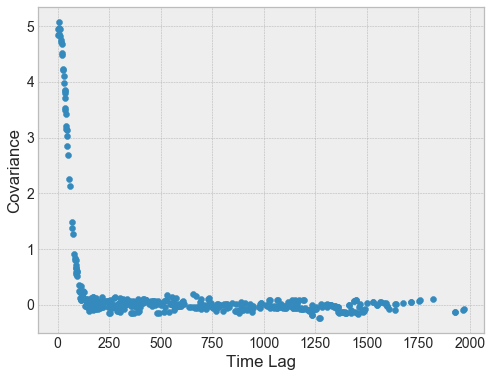

In [11]:
plt.scatter(d_tril, sigma_hat_tril)
plt.xlabel("Time Lag")
plt.ylabel("Covariance")

visualize coverage histogram for a single person (note that all people are iid)

(array([4.533e+03, 0.000e+00, 0.000e+00, 4.470e+02, 0.000e+00, 0.000e+00,
        1.900e+01, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

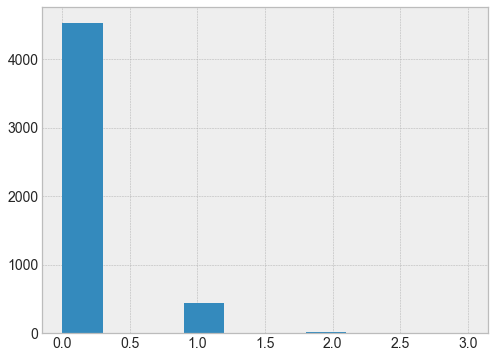

In [12]:
plt.hist(sim["c"][0,:])

visualize missingness across snps

## Custom RV

In [14]:
class distributions_BinomialMixture(Distribution):
    """
    """
    def __init__(self, total_count, f, p,
                 validate_args=False,
                 allow_nan_stats=True,
                 name="Custom"):
        self._total_count = total_count
        self._f = f
        self._p = p
        super(distributions_CustomRandomVariable, self).__init__(
            dtype=tf.float32,
            reparameterization_type=tf.contrib.distributions.FULLY_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            name=name)

    def _log_prob(self, value):
        #return NormalWithSoftplusScale(loc=self._loc, scale=self._scale)._log_prob(value)
        pass
        
    def _sample_n(self, n, seed=None):
        raise NotImplementedError("sample_n is not implemented")

class BinomialMixture(RandomVariable, distributions_BinomialMixture):
    def __init__(self, *args, **kwargs):
        RandomVariable.__init__(self, *args, **kwargs)

IndentationError: expected an indented block (<ipython-input-14-238b47e6a9e7>, line 20)

## Model

In [13]:
t_ph = tf.placeholder(tf.float32, [n, 1]) # placeholder for age of each sample
c_ph = tf.placeholder(tf.float32, [p, n]) # placeholder for coverage of each sample and snp

sigma2 = tf.nn.softplus(tf.get_variable("sigma2", []))
l2 = tf.nn.softplus(tf.get_variable("l2", []))

In [ ]:
k = rbf(t_ph, lengthscale=l2, variance=sigma2) + (1e-6 * tf.eye(n))
f = MultivariateNormalTriL(loc=tf.zeros((p, n)), scale_tril=tf.cholesky(k))


## Inference

In [ ]:
q_f = Normal(loc=tf.get_variable("q_f/loc", [p, n]), 
             scale=tf.nn.softplus(tf.get_variable("q_f/scale", [p, n])))